<a href="https://colab.research.google.com/github/rajatgarg01/sugracane_breed/blob/main/sugarcane_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import zipfile


In [ ]:
import torch
import torch.nn as nn
from torchvision import models

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
with zipfile.ZipFile("/content/BG-white photos -20250729T051231Z-1-001.zip", 'r') as zip_ref:
    zip_ref.extractall("sugarcane_data")  # Unzips to a new folder

**transforms.Resize((224, 224))**
🔹 Resizes the image to a fixed 224x224 pixels (input size expected by most pretrained models like ResNet, MobileNet, etc.).

**transforms.RandomHorizontalFlip()**
🔹 Randomly flips the image left-right with a probability of 0.5.
🔸 Helps model learn that left-right direction doesn't change class.

**transforms.RandomRotation(20)**
🔹 Rotates the image randomly within ±20 degrees.
🔸 Adds angle invariance — useful for slight camera tilts.

**transforms.ColorJitter(brightness=0.3, contrast=0.3)**
🔹 Randomly changes brightness and contrast up to ±30%.
🔸 Simulates lighting changes, improving generalization.

**transforms.ToTensor()**
🔹 Converts image (PIL or NumPy) to PyTorch tensor (C×H×W format).
🔸 Pixel values scaled from [0, 255] → [0.0, 1.0].

**transforms.Normalize(mean, std)**
🔹 Normalizes each RGB channel to zero mean and unit variance using:

In [ ]:
# Mean and std can be estimated or use ImageNet values
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

# Train Transform (with Augmentation)
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Test/Validation Transform (no augmentation)
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


In [ ]:
data_dir = '/content/sugarcane_data/BG-white photos '  # adjust if needed

In [ ]:


# Use ImageFolder
full_dataset = datasets.ImageFolder(root=data_dir, transform=train_transforms)

# Split into train/test (e.g. 80/20)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])
test_dataset.dataset.transform = test_transforms  # apply test transform

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


Verify a Batch of Images

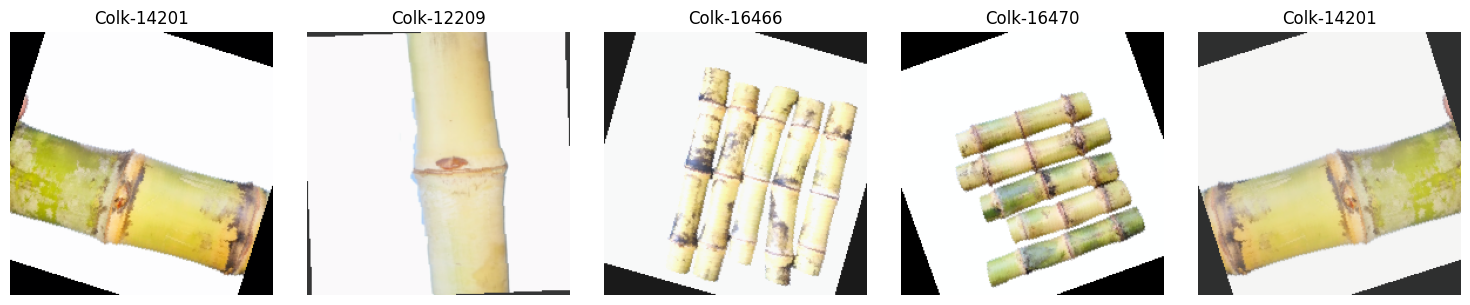

In [ ]:
# Function to denormalize and show image
def imshow(img_tensor):
    img = img_tensor.numpy().transpose((1, 2, 0))  # CxHxW -> HxWxC
    img = img * np.array(std) + np.array(mean)     # Unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')

# Load dataset with transform
dataset = datasets.ImageFolder(root=data_dir, transform=train_transforms)

# Visualize 5 Augmented Images from One Class
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    img, label = dataset[np.random.randint(0, len(dataset))]
    plt.subplot(1, 5, i + 1)
    imshow(img)
    plt.title(dataset.classes[label])
plt.tight_layout()
plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [ ]:
# Load pretrained ResNet18
resnet18_model = models.resnet18(pretrained=True)

# Freeze all layers first
for param in resnet18_model.parameters():
    param.requires_grad = False

# Replace last fully connected layer
num_classes = len(full_dataset.classes)
resnet18_model.fc = nn.Linear(resnet18_model.fc.in_features, num_classes)

# Unfreeze the final layer only
for param in resnet18_model.fc.parameters():
    param.requires_grad = True

resnet18_model = resnet18_model.to(device)

# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18_model.fc.parameters(), lr=0.001)

# Training Loop
num_epochs = 25
for epoch in range(num_epochs):
    resnet18_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = resnet18_model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100*correct/total:.2f}%")

Epoch [1/25], Loss: 1.9270, Accuracy: 17.46%
Epoch [2/25], Loss: 1.5639, Accuracy: 30.16%
Epoch [3/25], Loss: 1.4189, Accuracy: 52.38%
Epoch [4/25], Loss: 1.2860, Accuracy: 66.67%
Epoch [5/25], Loss: 1.0783, Accuracy: 71.43%
Epoch [6/25], Loss: 1.0436, Accuracy: 73.02%
Epoch [7/25], Loss: 1.0504, Accuracy: 63.49%
Epoch [8/25], Loss: 0.9013, Accuracy: 82.54%
Epoch [9/25], Loss: 0.8199, Accuracy: 82.54%
Epoch [10/25], Loss: 0.7860, Accuracy: 80.95%
Epoch [11/25], Loss: 0.6637, Accuracy: 88.89%
Epoch [12/25], Loss: 0.6476, Accuracy: 88.89%
Epoch [13/25], Loss: 0.6628, Accuracy: 90.48%
Epoch [14/25], Loss: 0.6357, Accuracy: 85.71%
Epoch [15/25], Loss: 0.5166, Accuracy: 93.65%
Epoch [16/25], Loss: 0.5804, Accuracy: 90.48%
Epoch [17/25], Loss: 0.4459, Accuracy: 95.24%
Epoch [18/25], Loss: 0.4474, Accuracy: 96.83%
Epoch [19/25], Loss: 0.4325, Accuracy: 93.65%
Epoch [20/25], Loss: 0.5920, Accuracy: 87.30%
Epoch [21/25], Loss: 0.3869, Accuracy: 95.24%
Epoch [22/25], Loss: 0.4381, Accuracy: 95.2

In [ ]:
import pandas as pd
import torch.nn.functional as F

model.eval()
all_preds = []
all_labels = []
all_filenames = []

with torch.no_grad():
    for batch_idx, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        probs = F.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Get the original indices for the current batch
        # The indices in the test_loader are relative to the test_dataset subset
        # We need to map these back to the original full_dataset indices
        start_idx = batch_idx * test_loader.batch_size
        end_idx = start_idx + inputs.size(0) # Use inputs.size(0) to handle the last batch
        original_indices = test_loader.dataset.indices[start_idx:end_idx]

        # Get filenames for the current batch using original indices
        filenames = [full_dataset.samples[i][0] for i in original_indices]
        all_filenames.extend(filenames)

In [ ]:
# Map class indices to class names
idx_to_class = {v: k for k, v in full_dataset.class_to_idx.items()}

df = pd.DataFrame({
    "Image": all_filenames,
    "True Label": [idx_to_class[i] for i in all_labels],
    "Predicted Label": [idx_to_class[i] for i in all_preds],
})

# Add a column to mark correct/wrong predictions
df["Correct"] = df["True Label"] == df["Predicted Label"]

In [ ]:
errors_df = df[df["Correct"] == False]

In [ ]:
df

,Image,True Label,Predicted Label,Correct
0,/content/sugarcane_data/BG-white photos /Colk-...,Colk-16470,Colk-16470,True
1,/content/sugarcane_data/BG-white photos /Colk-...,Colk-94184,Colk-94184,True
2,/content/sugarcane_data/BG-white photos /Colk-...,Colk-94184,Colk-94184,True
3,/content/sugarcane_data/BG-white photos /Colk-...,Colk-15466,Colk-15466,True
4,/content/sugarcane_data/BG-white photos /Colk-...,Colk-12209,Colk-12209,True
5,/content/sugarcane_data/BG-white photos /Colk-...,Colk-16466,Colk-16466,True
6,/content/sugarcane_data/BG-white photos /Colk-...,Colk-94184,Colk-94184,True
7,/content/sugarcane_data/BG-white photos /Colk-...,Colk-16470,Colk-16470,True
8,/content/sugarcane_data/BG-white photos /Colk-...,Colk-16466,Colk-16466,True
9,/content/sugarcane_data/BG-white photos /Colk-...,Colk-14201,Colk-14201,True


In [ ]:
print(errors_df.head(20))  # Show first 10 misclassified samples
errors_df.to_csv("misclassifications.csv", index=False)  # Save to CSV


Empty DataFrame
Columns: [Image, True Label, Predicted Label, Correct]
Index: []


In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import os

def show_misclassified_images(df, num_images=9):
    plt.figure(figsize=(12, 10))

    for i in range(min(num_images, len(df))):
        img_path = df.iloc[i]['Image']
        true_label = df.iloc[i]['True Label']
        pred_label = df.iloc[i]['Predicted Label']

        # Load and display the image
        img = Image.open(img_path)

        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"True: {true_label}\nPred: {pred_label}", color='red' if true_label != pred_label else 'green')

    plt.tight_layout()
    plt.show()


In [ ]:
show_misclassified_images(errors_df, num_images=9)


<Figure size 1200x1000 with 0 Axes>

In [ ]:

# Load the model
efficientnet_b0_model = models.efficientnet_b0(pretrained=True)

# Freeze all layers
for param in efficientnet_b0_model.parameters():
    param.requires_grad = False

# Replace classifier head
num_classes = 6  # Change if you have different number of sugarcane breeds
efficientnet_b0_model.classifier[1] = nn.Linear(efficientnet_b0_model.classifier[1].in_features, num_classes)

# Unfreeze the classifier layer
for param in efficientnet_b0_model.classifier[1].parameters():
    param.requires_grad = True

# Move to GPU (if available)
efficientnet_b0_model = efficientnet_b0_model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(efficientnet_b0_model.classifier[1].parameters(), lr=1e-3)


In [ ]:
num_epochs = 25

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = efficientnet_b0_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}")


Epoch [1/25], Loss: 13.8193
Epoch [2/25], Loss: 12.4182
Epoch [3/25], Loss: 11.0797
Epoch [4/25], Loss: 10.1229
Epoch [5/25], Loss: 8.9728
Epoch [6/25], Loss: 7.8585
Epoch [7/25], Loss: 7.9586
Epoch [8/25], Loss: 7.0727
Epoch [9/25], Loss: 6.6446
Epoch [10/25], Loss: 5.6867
Epoch [11/25], Loss: 5.2279
Epoch [12/25], Loss: 5.4112
Epoch [13/25], Loss: 4.9316
Epoch [14/25], Loss: 4.4522
Epoch [15/25], Loss: 3.5576
Epoch [16/25], Loss: 5.8894
Epoch [17/25], Loss: 4.0193
Epoch [18/25], Loss: 3.4086
Epoch [19/25], Loss: 3.5608
Epoch [20/25], Loss: 4.5528
Epoch [21/25], Loss: 4.8516
Epoch [22/25], Loss: 3.7304
Epoch [23/25], Loss: 2.9443
Epoch [24/25], Loss: 2.9418
Epoch [25/25], Loss: 3.2782


In [ ]:
class_names = full_dataset.classes

Accuracy: 0.81
Classification Report:

              precision    recall  f1-score   support

  Colk-12209       0.00      0.00      0.00         1
  Colk-14201       1.00      0.50      0.67         2
  Colk-15466       0.67      1.00      0.80         2
  Colk-16466       1.00      1.00      1.00         4
  Colk-16470       0.75      1.00      0.86         3
  Colk-94184       0.75      0.75      0.75         4

    accuracy                           0.81        16
   macro avg       0.69      0.71      0.68        16
weighted avg       0.79      0.81      0.78        16



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


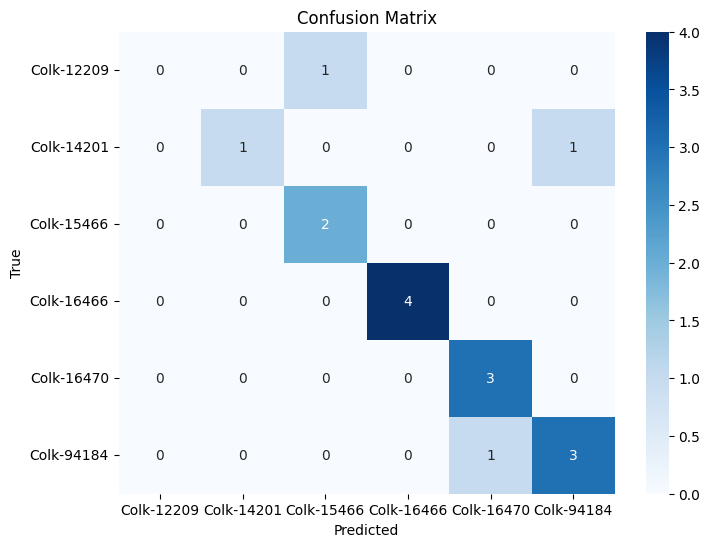

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

efficientnet_b0_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = efficientnet_b0_model(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Accuracy
acc = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {acc:.2f}")

# Classification report
print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt
import torch

misclassified_images = []
true_classes = []
predicted_classes = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        for i in range(images.size(0)):
            if preds[i] != labels[i]:
                misclassified_images.append(images[i].cpu())
                true_classes.append(labels[i].item())
                predicted_classes.append(preds[i].item())

# Denormalization helper
inv_normalize = transforms.Normalize(
    mean=[-m/s for m, s in zip(mean, std)],
    std=[1/s for s in std]
)

# Plot misclassified images
def show_misclassified(images, true_labels, pred_labels, class_names, n=9):
    plt.figure(figsize=(12, 10))
    for i in range(min(n, len(images))):
        img = inv_normalize(images[i])
        img = torch.clamp(img, 0, 1)
        img = img.permute(1, 2, 0).numpy()
        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.title(f"True: {class_names[true_labels[i]]} | Pred: {class_names[pred_labels[i]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_misclassified(misclassified_images, true_classes, predicted_classes, class_names)

<Figure size 1200x1000 with 0 Axes>

Resnet50

In [ ]:
# Load ResNet50 with pretrained ImageNet weights
resnet50 = models.resnet50(pretrained=True)

# Freeze early layers (optional, can be fine-tuned later)
for param in resnet50.parameters():
    param.requires_grad = False

# Replace the final fully connected layer
num_classes = 6  # change if different
resnet50.fc = nn.Linear(resnet50.fc.in_features, num_classes)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50 = resnet50.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.fc.parameters(), lr=0.001)  # training only the final layer


In [ ]:
num_epochs = 25

for epoch in range(num_epochs):
    resnet50.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet50(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


Epoch [1/25], Loss: 1.9214
Epoch [2/25], Loss: 1.6782
Epoch [3/25], Loss: 1.3133
Epoch [4/25], Loss: 1.2764
Epoch [5/25], Loss: 1.1534
Epoch [6/25], Loss: 0.9138
Epoch [7/25], Loss: 0.9569
Epoch [8/25], Loss: 0.7514
Epoch [9/25], Loss: 0.7201
Epoch [10/25], Loss: 0.6264
Epoch [11/25], Loss: 0.6393
Epoch [12/25], Loss: 0.6489
Epoch [13/25], Loss: 0.5683
Epoch [14/25], Loss: 0.5578
Epoch [15/25], Loss: 0.5115
Epoch [16/25], Loss: 0.4974
Epoch [17/25], Loss: 0.4233
Epoch [18/25], Loss: 0.4107
Epoch [19/25], Loss: 0.4054
Epoch [20/25], Loss: 0.3901
Epoch [21/25], Loss: 0.3113
Epoch [22/25], Loss: 0.3334
Epoch [23/25], Loss: 0.2916
Epoch [24/25], Loss: 0.3235
Epoch [25/25], Loss: 0.2557


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

resnet50.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = resnet50(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Evaluation
print("Classification Report:\n", classification_report(all_labels, all_preds))
print("Confusion Matrix:\n", confusion_matrix(all_labels, all_preds))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      0.50      0.67         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         3
           5       0.80      1.00      0.89         4

    accuracy                           0.94        16
   macro avg       0.97      0.92      0.93        16
weighted avg       0.95      0.94      0.93        16

Confusion Matrix:
 [[1 0 0 0 0 0]
 [0 1 0 0 0 1]
 [0 0 2 0 0 0]
 [0 0 0 4 0 0]
 [0 0 0 0 3 0]
 [0 0 0 0 0 4]]


Total Misclassified Images: 1


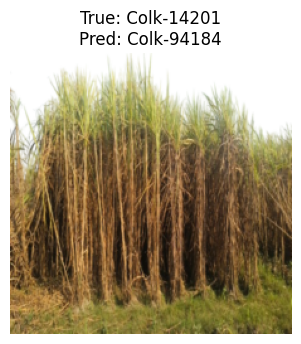

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Helper to denormalize
def denormalize(img_tensor, mean, std):
    for t, m, s in zip(img_tensor, mean, std):
        t.mul_(s).add_(m)
    return img_tensor

# Mean and std used in transforms
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

# List to store misclassified samples
misclassified = []

resnet50.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet50(images)
        _, preds = torch.max(outputs, 1)

        for img, pred, label in zip(images, preds, labels):
            if pred != label:
                misclassified.append((img.cpu(), pred.cpu(), label.cpu()))

# Show a few misclassified images
classes = full_dataset.classes  # Get class names from the original dataset

print(f"Total Misclassified Images: {len(misclassified)}")

plt.figure(figsize=(12, 10))
for i in range(min(12, len(misclassified))):
    img, pred, label = misclassified[i]
    img = denormalize(img.clone(), mean, std)
    img = img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)

    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"True: {classes[label]}\nPred: {classes[pred]}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
import torch.nn.functional as F

resnet18_model.eval()
efficientnet_b0_model.eval() # efficientnet_b0 model
resnet50.eval()

final_preds = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        true_labels.extend(labels.cpu().numpy())

        # Get softmax probabilities from each model
        probs1 = F.softmax(resnet18_model(images), dim=1)
        probs2 = F.softmax(model(images), dim=1) # efficientnet_b0 model
        probs3 = F.softmax(resnet50(images), dim=1)

        # Average probabilities (simple soft-voting)
        avg_probs = (probs1 + probs2 + probs3) / 3.0

        # Final prediction
        preds = torch.argmax(avg_probs, dim=1)
        final_preds.extend(preds.cpu().numpy())

Classification Report:

              precision    recall  f1-score   support

  Colk-12209       1.00      1.00      1.00         1
  Colk-14201       1.00      0.50      0.67         2
  Colk-15466       1.00      1.00      1.00         2
  Colk-16466       1.00      1.00      1.00         4
  Colk-16470       1.00      1.00      1.00         3
  Colk-94184       0.80      1.00      0.89         4

    accuracy                           0.94        16
   macro avg       0.97      0.92      0.93        16
weighted avg       0.95      0.94      0.93        16



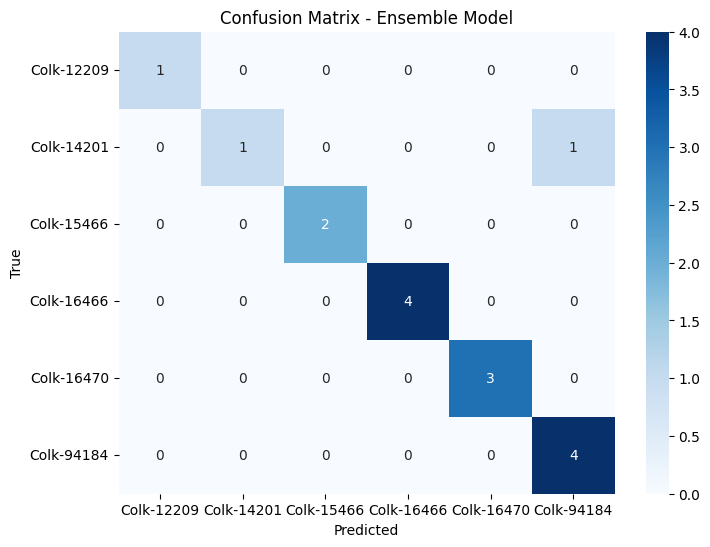

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("Classification Report:\n")
print(classification_report(true_labels, final_preds, target_names=full_dataset.classes))

cm = confusion_matrix(true_labels, final_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=full_dataset.classes, yticklabels=full_dataset.classes, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Ensemble Model")
plt.show()